<a href="https://colab.research.google.com/github/ScoobanyLoLo/Colab/blob/main/deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')


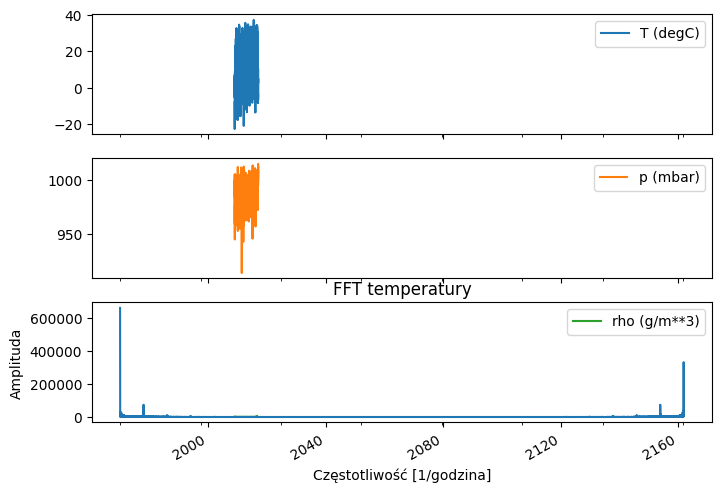

Epoch 1/3


ValueError: Shapes used to initialize variables must be fully-defined (no `None` dimensions). Received: shape=(None, 512) for variable path='sequential_15/dense_23/kernel'

In [4]:
# Importujemy wszystkie niezbędne biblioteki
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# Konfiguracja wyglądu wykresów: rozmiar i brak siatki
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
import pandas as pd
import os
import zipfile
# Pobieramy spakowany zbiór danych pogodowych
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=False # NIE rozpakowujemy automatycznie
)
# Ścieżka do katalogu, gdzie zapisano plik
extract_path = os.path.dirname(zip_path)
# Ręcznie rozpakowujemy plik ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
# Uzyskujemy poprawną ścieżkę do pliku CSV
csv_path = os.path.join(extract_path, 'jena_climate_2009_2016.csv')
# TEST: sprawdzamy, czy plik CSV istnieje
assert os.path.exists(csv_path), f"Plik {csv_path} nie istnieje!"
# Wczytujemy dane z pliku CSV do obiektu DataFrame
df = pd.read_csv(csv_path)
# Redukujemy zbiór danych, wybierając co 6-ty pomiar (zachowujemy tylko 1 pomiar na godzinę)
df = df[5::6]
# Konwertujemy kolumnę 'Date Time' na typ datetime i usuwamy ją z oryginalnej ramki danych
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# Wyświetlamy pierwsze kilka wierszy danych, aby sprawdzić strukturę
df.head()
# Wyświetlamy listę wszystkich kolumn dostępnych w zbiorze danych
print(df.columns)
# Rysujemy wykres pokazujący zmiany jednej z wybranych zmiennych w czasie (np. temperatury)
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
# Tworzymy wykres z trzema zmiennymi
plot_features.plot(subplots=True)

# Naprawiamy błędne wartości prędkości wiatru (-9999) zamieniając je na 0
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
# Podobnie poprawiamy zmienną 'max. wv (m/s)'
wv_max = df['max. wv (m/s)']
bad_wv_max = wv_max == -9999.0
wv_max[bad_wv_max] = 0.0
# Konwertujemy prędkość i kierunek wiatru na składowe wektorowe Wx i Wy
# Dla aktualnej prędkości wiatru
wd_rad = df['wd (deg)'] * np.pi / 180
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)
# Dla maksymalnej prędkości wiatru
wd_rad = df['wd (deg)'] * np.pi / 180
df['max Wx'] = wv_max * np.cos(wd_rad)
df['max Wy'] = wv_max * np.sin(wd_rad)
# Usuwamy oryginalne kolumny kierunku i prędkości wiatru
df.drop(['wv (m/s)', 'max. wv (m/s)', 'wd (deg)'], axis=1, inplace=True)
# Wyodrębniamy wartości czasowe: godzinę w ciągu dnia i dzień w roku
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day
# Dodajemy zmienne sinusoidalne odwzorowujące zmienność dobową i roczną
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# Funkcja wykonująca szybką transformację Fouriera (FFT)
def fft(dft, column):
    f = np.fft.fft(dft[column])
    f = np.abs(f)
    return f
# Wykonujemy FFT na zmiennej 'T (degC)' (temperatura)
fft_temp = fft(df, 'T (degC)')
# Rysujemy wynik FFT
plt.plot(np.arange(len(fft_temp)), fft_temp)
plt.xlabel('Częstotliwość [1/godzina]')
plt.ylabel('Amplituda')
plt.title('FFT temperatury')
plt.show()

# Ustalamy indeksy podziału danych
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
# Tworzymy obiekt normalizatora na podstawie zbioru treningowego
train_mean = train_df.mean()
train_std = train_df.std()
# Normalizujemy dane: odejmujemy średnią i dzielimy przez odchylenie standardowe
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# Definiujemy klasę pomocniczą do tworzenia okien danych
OUT_STEPS = 24
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        return inputs, labels
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = next(iter(self.train.take(1)))
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [norm]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Wejście', marker='.', zorder=-10)
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Etykiety', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predykcje',
                            c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
        plt.xlabel('Czas [kroki]')
        plt.show()
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result
window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['T (degC)'])

# Definiujemy bardzo prosty model bazowy - przewidujemy ostatnią znaną wartość
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

# Budujemy prosty model sieci neuronowej typu Dense
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# Tworzymy model konwolucyjny do analizy szeregów czasowych
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(3,),
                           activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# Budujemy model rekurencyjny LSTM
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

# Funkcja do kompilacji i treningu modelu
MAX_EPOCHS = 3
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=patience,
                                                       mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

# Tworzymy model gęsty do predykcji wielu kroków naraz
label_width = window.label_width
num_features = train_df.shape[-1]
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(label_width*num_features),
    tf.keras.layers.Reshape([label_width, num_features])
])

# Tworzymy model do prognozowania wielu zmiennych jednocześnie
multi_out_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

# Model LSTM do prognozowania wielu cech jednocześnie
multi_out_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=num_features)
])

# Definiujemy model autoregresyjny LSTM
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

# Trenujemy modele wielokrokowe, wielowymiarowe i autoregresyjne
compile_and_fit(multi_dense_model, window)
compile_and_fit(multi_out_dense, window)
compile_and_fit(multi_out_lstm, window)
# Dla modelu autoregresyjnego
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
compile_and_fit(feedback_model,window)
